In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(37) # 使得每次运行得到的随机数都一样

In [2]:
# 准备数据集，使用tushare来获取股票数据
# 准备几个函数，用来获取数据
import tushare as ts
def get_K_dataframe(code,start,end):
    '''get day-K data of code, from start date to end date
       params:
            code: stock code eg: 600123, 002743 
            start: start date, eg: 2016-10-01
            end: end date, eg: 2016-10-31
        return:
            dataframe with columns [date, open, close, high, low]
    '''
    df=ts.get_k_data(code,start=start,end=end)
    df.drop(['volume'],axis=1, inplace=True)
    return df

In [3]:
def get_batch_K_df(codes_list,start,end):
    '''get batch stock K data'''
    df=pd.DataFrame()
    print('fetching data. pls wait...')
    for code in codes_list:
        # print('fetching K data of {}...'.format(code))
        df=df.append(get_K_dataframe(code,start,end))
    return df

In [4]:
# 数据规整函数，用于对获取的df进行数据处理
def preprocess_data(stock_df,min_K_num=1000):
    '''preprocess the stock data.
    Notice: min_K_num: the minimum stock K number.
        because some stocks was halt trading in this time period, 
        the some K data was missing. 
        if the K data number is less than min_K_num, the stock is discarded.'''
    df=stock_df.copy()
    df['diff']=df.close-df.open  # 此处用收盘价与开盘价的差值做分析
    df.drop(['open','close','high','low'],axis=1,inplace=True)
    
    result_df=None 
    #下面一部分是将不同的股票diff数据整合为不同的列，列名为股票代码
    for name, group in df[['date','diff']].groupby(df.code):
        if len(group.index)<min_K_num: continue
        if result_df is None:
            result_df=group.rename(columns={'diff':name})
        else:
            result_df=pd.merge(result_df,
                                group.rename(columns={'diff':name}),
                                on='date',how='inner') # 一定要inner，要不然会有很多日期由于股票停牌没数据
    
    result_df.drop(['date'],axis=1,inplace=True)
    # 然后将股票数据DataFrame转变为np.ndarray
    stock_dataset=np.array(result_df).astype(np.float64)
    # 数据归一化，此处使用相关性而不是协方差的原因是在结构恢复时更高效
    stock_dataset/=np.std(stock_dataset,axis=0)
    return stock_dataset,result_df.columns.tolist()

In [5]:
# 上面准备了各种函数，下面开始准备数据集
# 我们此处分析上证50指数的成分股，看看这些股票有哪些特性
sz50_df=ts.get_sz50s()
stock_list=sz50_df.code.tolist()
# print(stock_list) # 没有问题
batch_K_data=get_batch_K_df(stock_list,start='2013-09-01',end='2018-09-01') # 查看最近五年的数据
print(batch_K_data.info())

e:\programsoft\python\lib\site-packages\tushare\stock\classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


fetching data. pls wait...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56246 entries, 158 to 1356
Data columns (total 6 columns):
date     56246 non-null object
open     56246 non-null float64
close    56246 non-null float64
high     56246 non-null float64
low      56246 non-null float64
code     56246 non-null object
dtypes: float64(4), object(2)
memory usage: 3.0+ MB
None


In [6]:
stock_dataset,selected_stocks=preprocess_data(batch_K_data,min_K_num=1100)
print(stock_dataset.shape)  # (603, 41) 由此可以看出得到了603个交易日的数据，其中有41只股票被选出。
# 其他的9只股票因为不满足最小交易日的要求而被删除。这603个交易日是所有41只股票都在交易，都没有停牌的数据。
print(selected_stocks) # 这是实际使用的股票列表

(603, 41)
['600000', '600016', '600019', '600028', '600029', '600030', '600036', '600048', '600050', '600104', '600111', '600276', '600340', '600519', '600547', '600585', '600690', '600703', '600887', '600999', '601006', '601088', '601166', '601169', '601186', '601288', '601318', '601328', '601336', '601390', '601398', '601601', '601628', '601668', '601688', '601766', '601800', '601818', '601857', '601988', '603993']


In [7]:
# 从相关性中学习其图形结构
from sklearn.covariance import GraphLassoCV
edge_model=GraphLassoCV()
edge_model.fit(stock_dataset)

e:\programsoft\python\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

In [8]:
# 使用近邻传播算法构建模型，并训练LassoCV graph
from sklearn.cluster import affinity_propagation
_,labels=affinity_propagation(edge_model.covariance_)

In [9]:
n_labels=max(labels) 
# 对这41只股票进行了聚类，labels里面是每只股票对应的类别标号
print('Stock Clusters: {}'.format(n_labels+1)) # 10，即得到10个类别
sz50_df2=sz50_df.set_index('code')
# print(sz50_df2)
for i in range(n_labels+1):
    # print('Cluster: {}----> stocks: {}'.format(i,','.join(np.array(selected_stocks)[labels==i]))) # 这个只有股票代码而不是股票名称
    # 下面打印出股票名称，便于观察
    stocks=np.array(selected_stocks)[labels==i].tolist()
    names=sz50_df2.loc[stocks,:].name.tolist()
    print('Cluster: {}----> stocks: {}'.format(i,','.join(names)))

Stock Clusters: 10
Cluster: 0----> stocks: 宝钢股份,南方航空,华夏幸福,海螺水泥,中国神华
Cluster: 1----> stocks: 中信证券,保利地产,招商证券,华泰证券
Cluster: 2----> stocks: 北方稀土,洛阳钼业
Cluster: 3----> stocks: 恒瑞医药,三安光电
Cluster: 4----> stocks: 山东黄金
Cluster: 5----> stocks: 贵州茅台,青岛海尔,伊利股份
Cluster: 6----> stocks: 中国联通,大秦铁路,中国铁建,中国中铁,中国建筑,中国中车,中国交建
Cluster: 7----> stocks: 中国平安,新华保险,中国太保,中国人寿
Cluster: 8----> stocks: 浦发银行,民生银行,招商银行,上汽集团,兴业银行,北京银行,农业银行,交通银行,工商银行,光大银行,中国银行
Cluster: 9----> stocks: 中国石化,中国石油


In [10]:
from sklearn import manifold
from matplotlib.collections import LineCollection

# 对这些结果进行可视化
def visual_stock_relationship(dataset,edge_model,labels,stock_names):
    node_position_model = manifold.LocallyLinearEmbedding(
        n_components=2, eigen_solver='dense', n_neighbors=6)

    embedding = node_position_model.fit_transform(dataset.T).T
    
    plt.figure(1, facecolor='w', figsize=(10, 8))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Display a graph of the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
                cmap=plt.cm.nipy_spectral)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r,
                        norm=plt.Normalize(0, .7 * values.max()))
    lc.set_array(values)
    lc.set_linewidths(15 * values)
    ax.add_collection(lc)

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    n_labels=max(labels) 
    for index, (name, label, (x, y)) in enumerate(
            zip(stock_names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .001
        else:
            horizontalalignment = 'right'
            x = x - .001
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .001
        else:
            verticalalignment = 'top'
            y = y - .001
        plt.text(x, y, name, size=10,fontproperties = 'SimHei',
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                           alpha=.6))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())

    plt.show()

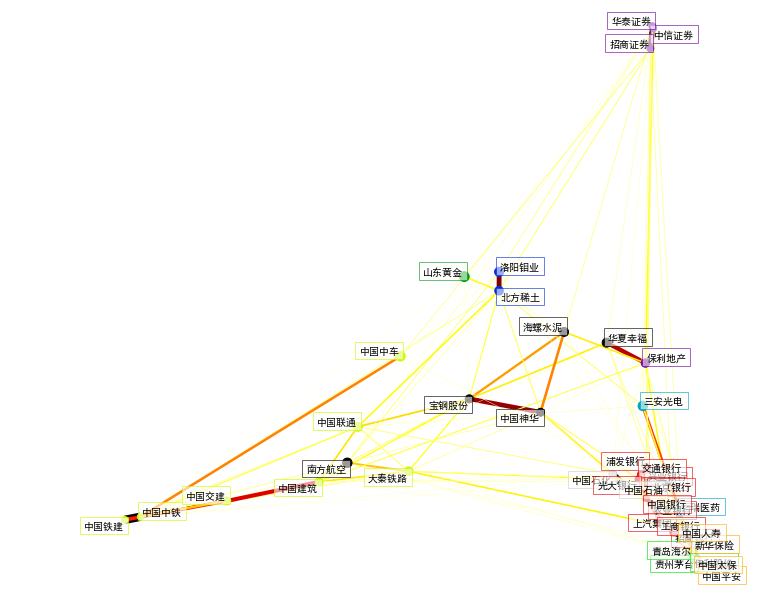

In [11]:
stock_names=sz50_df2.loc[selected_stocks,:].name.tolist()
visual_stock_relationship(stock_dataset,edge_model,labels,stock_names)